# D1 Data Analysis/Exploration

This notebook aims to explore the Switchboard corpus and extract some simple statistics.

In [22]:
import os
os.chdir("../../") # import convokit
import convokit
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import RegexpTokenizer

In [2]:
from convokit import meta_index
os.chdir("datasets/switchboard-corpus") # then come back for swda

meta_index(filename = "./corpus")

In [3]:
# Download corpus
corpus = convokit.Corpus(filename = "./corpus")
corpus.print_summary_stats()

Number of Users: 440
Number of Utterances: 221616
Number of Conversations: 1155


In [4]:
convo_ids = list(corpus.conversations.keys())
utt_ids = list(corpus.utterances.keys())

print('There are on average {:.0f} utterances per conversation'.format(len(corpus.utterances)/len(corpus.conversations)))
print('There are on average {:.0f} utterances per user'.format(len(corpus.utterances)/len(corpus.get_usernames())))

There are on average 192 utterances per conversation
There are on average 504 utterances per user


In [5]:
# How many unique pairs of speakers are there in the dataset? 
# i.e. is there any pair of people who speaks to each other in more than one conversation?

directed_pairs = corpus.speaking_pairs(user_names_only=True)
undirected_pairs = set()
for pair in directed_pairs:
    undirected_pairs.add(tuple(sorted(pair)))
    
print('There are {} directed speaker pairs (i.e.A replies to B and B replies to A are unique)'
      'and {} undirected pairs (A replies to B/B replies to A are the same) of speakers'
      .format(len(directed_pairs), len(undirected_pairs)))
print('Based on this, no two people speak to each other in more than one conversation')

There are 2310 directed speaker pairs (i.e.A replies to B and B replies to A are unique)and 1155 undirected pairs (A replies to B/B replies to A are the same) of speakers
Based on this, no two people speak to each other in more than one conversation


In [6]:
# Create users dictionary for easier analysis
users = {}
for u in corpus.utterances:
    users[corpus.utterances[u].user.name] = {}
    users[corpus.utterances[u].user.name]['sex'] = corpus.utterances[u].user.meta['sex']
    users[corpus.utterances[u].user.name]['education'] = corpus.utterances[u].user.meta['education']
    users[corpus.utterances[u].user.name]['birth_year'] = corpus.utterances[u].user.meta['birth_year']
    users[corpus.utterances[u].user.name]['dialect_area'] = corpus.utterances[u].user.meta['dialect_area']
        
print(len(users), 'total users')

440 total users


53.0% of the users are male, and 47.0% are female



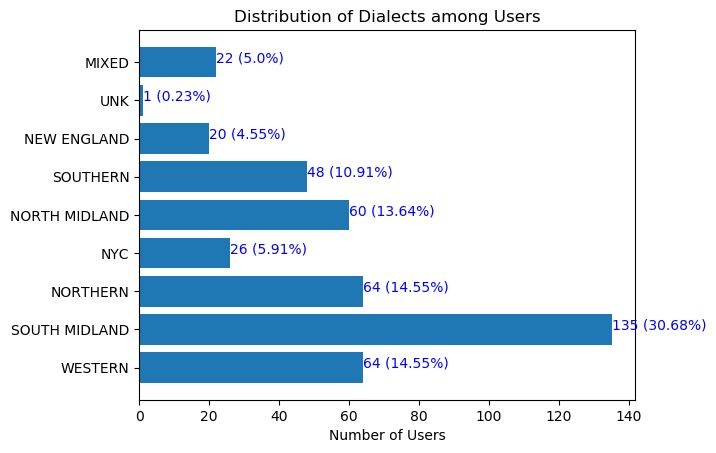

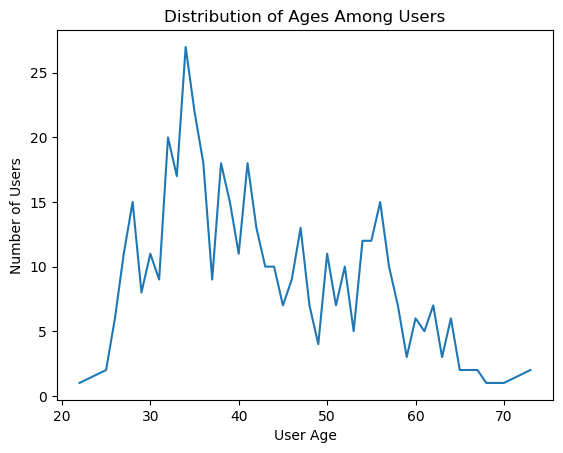

In [7]:
# What is the breakdown of user stats? i.e. distribution of sex, dialect, age?

female = 0
male = 0
dialects = {}
ages = {}
for u in users.keys():
    # Count num male and female
    if users[u]['sex'] == 'FEMALE':
        female += 1
    else:
        male += 1
        
    # Count each dialect
    if users[u]['dialect_area'] not in dialects:
        dialects[users[u]['dialect_area']] = 0
    dialects[users[u]['dialect_area']] += 1
    
    # Count each user's age (at 1997)
    age = 1997 - users[u]['birth_year']
    if age not in ages:
        ages[age] = 0
    ages[age] += 1
        
print('{0:0.1f}% of the users are male, and {1:0.1f}% are female\n'.format(100*male/len(users), 100*female/len(users)))

# Plot distribution of dialects
plt.rcdefaults()
fig, ax = plt.subplots()    

plt.barh(range(9), list(dialects.values()), align='center')
plt.yticks(range(9),dialects.keys())
for i, v in enumerate(list(dialects.values())):
    ax.text(v, i, str(v)+' ('+str(round(100*v/len(users),2))+'%)', color='blue')
plt.title('Distribution of Dialects among Users')
plt.xlabel('Number of Users')
plt.show()


# Plot distribution of ages (This dataset was collected in 1997 so all ages are from that year)

keys = np.array(list(ages.keys()))
values = np.array(list(ages.values()))
to_sort = np.argsort(keys)

fig, ax = plt.subplots()    
plt.plot(keys[to_sort], values[to_sort])
plt.xlabel('User Age')
plt.ylabel('Number of Users')
plt.title('Distribution of Ages Among Users')
plt.show()

In [8]:
# What is the average number of utterances a person says in a row? Min (1)? Max?
total_lines = 0
total_groupings = 0
lines = 0
max_lines = 0
cur_user = ''
cur_convo_id = ''

for i, u in enumerate(corpus.utterances):
    if i == 0:    # first utterance 
        cur_user = corpus.utterances[u].user.name
        cur_convo_id = corpus.utterances[u].root
        lines = 1
    
    elif cur_user != corpus.utterances[u].user.name or cur_convo_id != corpus.utterances[u].root:
        # if new speaker, restart count
        total_lines += lines
        total_groupings += 1
        max_lines = max(lines, max_lines)
        cur_user = corpus.utterances[u].user.name
        cur_convo_id = corpus.utterances[u].root
        lines = 1
        
    else:
        # continuing their speech:
        lines += 1

print('Total number of lines:', total_lines)
print('Total number of groupings of lines:', total_groupings)
print('Average number of utterances a person makes in a row:', total_lines/total_groupings)
print('Max number of utterances a person says in a row:', max_lines)

Total number of lines: 221615
Total number of groupings of lines: 123800
Average number of utterances a person makes in a row: 1.7901050080775445
Max number of utterances a person says in a row: 30


In [28]:
# In an average conversation, what is the % breakdown of speaking between users by number of tokens? 

user_1 = ''
user_2 = ''
user_1_tokens = 0
user_2_tokens = 0
cur_convo_id = ''
total_tokens = 0
tokenizer = RegexpTokenizer(r'\w+')

for i, u in enumerate(corpus.utterances):
    tokens = tokenizer.tokenize(corpus.utterances[u].text)
    
    if corpus.utterances[u].root != cur_convo_id:
        # new conversation
        user_1 = corpus.utterances[u].user.name  # user 1 is first person to speak 
        cur_convo_id = corpus.utterances[u].root 
        
    if corpus.utterances[u].user.name == user_1:
        user_1_tokens += len(tokens)
    else:
        user_2_tokens += len(tokens)
    total_tokens += len(tokens)
    
print('User 1 speaks {0:0.1f}% of tokens and User 2 speaks {1:0.1f}% of tokens'.format(100*user_1_tokens/total_tokens, 100*user_2_tokens/total_tokens))



User 1 speaks 51.7% of the tokens and User 2 speaks 48.3% of the tokens


In [ ]:
# What is the breakdown of conversation topics/prompts?